In [1]:
# import sys
# !{sys.executable} -m pip install qutip
import numpy as np
import matplotlib.pyplot as plt
from arc import *  # Import ARC (Alkali Rydberg Calculator)
from qutip import *
from scipy.fft import fft, ifft
from scipy import constants 
from Alk_atom import alk_atom
from PIL import Image

In [2]:
# Here is the Class alk_atom created by Maimouna Bocoum - 01-08-2023
class alk_atom:
    def __init__(self,myList:list):
        # test the type of the list and trck error
        #try:
            self.MakeAtomFromList(myList)

        # except:
        #     print("error in construction format inpout. exemple of acceptable inpout: [ [0,[3,4]] , [1,[3,4]] ]")
        # pass

    def AddLeveltoList(self,Level:list):
          # Level exemple of list structure: [0,[1,2]], for l=0 ; F=1 and F=2
        self.LevelList.append(Level)
        self.MakeAtomFromList()
        
    def MakeAtomFromList(self,myList):
            N = len(myList)
            self.LevelList = myList
            self.F = []
            self.L = []
            self.J = []
            self.M = []

            for loop in range(0,N):
                Line = myList[loop]  # get l orbital number. l=0 for 6S1/2 , l=1 for 6P1/2 and 6P3/2
                F = Line[2]          # get list of hyperfine F values
                for f in range(0,len(F)):
                     for m in range(0,F[f]*2+1):
                        self.L.append(Line[0])
                        self.J.append(Line[1])
                        self.F.append(F[f])
                        self.M.append( - F[f] + m )
                        
            self.N = len(self.M)

            # count how many levels are not in the ground state
            self.N_notground = 0
            for loop in range(0,self.N):
                if [self.L[loop] , self.J[loop] , self.F[loop]]!=[0,0.5,min(self.F)]:
                    self.N_notground = self.N_notground + 1

    def BuildMvector(self):
        self.M = []
        for i in range(0,len(self.F)):
             for m in range(0,self.F[i]*2+1):
                self.M.append( - self.F[i] + m )

    def printAtom(self):
        print(self.N)
        print(self.LevelList)
        print(self.L)
        print(self.J)
        print(self.F)
        print(self.M)

    #@classmethod
    def FetchKetIndex(self,Level:list):
         # get List of all elements
         # list is in the form [[],[],[],[]]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.J[loop],self.F[loop],self.M[loop]])
        return [ i for (i,e) in enumerate(KetList) if e == Level ]
    
    def FetchKetbyL(self,L):
         # L is 0 or 1 (0=ground state , 1=excited state)
         # list is in the form [[],[],[],[]]
         return [ i for (i,l) in enumerate(self.L) if l == L ]

    def FetchKetbyJ(self,J):
         return [ i for (i,j) in enumerate(self.J) if j == J ]
    
    def FetchKetbyM(self,M):
         return [ i for (i,m) in enumerate(self.M) if m == M ]
    
    def FetchKetbyLF(self,LF):
        # LF = [L,F]. To the F=3 or excited state for instance, LF = [1,3]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.F[loop]])
        return [ i for (i,lf) in enumerate(KetList) if lf == LF ]

    def FetchKetbyLM(self,LM):
        # LF = [L,F]. To the F=3 or excited state for instance, LF = [1,3]
        KetList = []
        for loop in range(0,self.N,1): # loop on off kets
            KetList.append([self.L[loop],self.M[loop]])
        return [ i for (i,lm) in enumerate(KetList) if lm == LM ]   

    def GetHPSDipolarElement(self,L1,J1,F1,M1,L2,J2,F2,M2,q):
        # transistion from (L1,J1,F1,M1) --> (L2,J2,F2,M2)
        Iatom = 7/2
        a = (-1)**(2*F2-1+M1+J1+1+Iatom)
        b = np.sqrt((2*F1 + 1) *(2.0 *F2 + 1) * (2 *J1 + 1))*Wigner6j(J2,J1,1,F1,F2,Iatom)*Wigner3j(F1,1,F2,M1,q,-M2)

        if abs(J1-J2) == 0:
            c = 3.182192647373821
        elif abs(J1-J2) == 1:
            c = 4.478602220001236
        else:
            raise Exception("Ckech J1 and J2 values!") 

        return a*b*c
    
    def GetHPSDipolarElementBranching(self,L1,J1,F1,M1,L2,J2,F2,M2,q):
        # transistion from (L1,J1,F1,M1) --> (L2,J2,F2,M2)
        Iatom = 7/2
        a = (-1)**(2*F2-1+M1+J1+1+Iatom)
        b = np.sqrt((2*F1 + 1) *(2.0 *F2 + 1) * (2 *J1 + 1))*Wigner6j(J2,J1,1,F1,F2,Iatom)*Wigner3j(F1,1,F2,M1,q,-M2)
        return (a*b)**2
    
    def GetHPSTransitionStrength(self,J,F1,F2):# F1->F2 transition S_FF' factor in Steck
            if J==0.5: # value for D1 line
                if F2==4:
                    if F1==4: # LEVEL FROM WHERE DECAY
                        S=5/12 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=7/12 
                elif F2==3:
                    if F1==4: # LEVEL FROM WHERE DECAY
                        S=3/4
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=1/4 
            elif J==1.5: # value for D1 line
                if F2==4:
                    if F1==2: # LEVEL FROM WHERE DECAY
                        S=0 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=7/72 
                    elif F1==4: # LEVEL FROM WHERE DECAY
                        S=7/24
                    if F1==5: # LEVEL FROM WHERE DECAY
                        S=11/18 
                elif F2==3:
                    if F1==2: # LEVEL FROM WHERE DECAY
                        S=5/14 
                    elif F1==3: # LEVEL FROM WHERE DECAY
                        S=3/8 
                    elif F1==4: # LEVEL FROM WHERE DECAY
                        S=15/56
                    elif F1==5: # LEVEL FROM WHERE DECAY
                        S=0  
                    else:# error cast
                        raise Exception("Sorry, wrong number!") 
            
            else:# error cast
                raise Exception("Sorry, wrong number!") 
            return S




In [3]:
# initialize the simulation
# preparation state for the MORS in list of [[l,j,[F]]]
myList = [ [0,0.5,[3,4]] , [1,1.5,[2,3,4,5]] ]
my_cesium = alk_atom(myList)
# my_cesium.printAtom()
# Load parameters for Caesium alk Library
atom = Caesium()
# energy of D2 line in eV :
#h = constants.physical_constants['Planck constant in eV/Hz'][0]
E_D2 = atom.getEnergy(6,1,1.5) - atom.getEnergy(6,0,0.5)
# convert to frequency
omega_D2 = 2*np.pi*E_D2/constants.physical_constants['Planck constant in eV/Hz'][0]
Eup   = atom.getHFSEnergyShift(1.5,2, atom.getHFSCoefficients(6,1,1.5)[0] , atom.getHFSCoefficients(6,1,1.5)[1])
Edown = atom.getHFSEnergyShift(0.5,3, atom.getHFSCoefficients(6,0,0.5)[0] , atom.getHFSCoefficients(6,0,0.5)[1])
omega_L = omega_D2 + 2*np.pi*(Eup - Edown)+ 0*np.pi*2e9  #F3->F'3 transtion frequency Hz
# initial field properties for quantum simulation
Power = 1e-3 ;            # field power in Watt
S     = (1e-3)*(5e-2)     # insident surface in m^2
phi   = 0                 # phase of the field
Delta = (omega_L-omega_D2)/(2*np.pi) # Detuning of the field (rotation frame wl = w0 + 2*pi*Delta , where w0 is D2 line) in Hz
Pol   = [0.5,0.5]             # distribution of polarization state [% of sigma+ , % of sigma-]

Bx = 0.5e-3       # Magnetic field along x in T
# constants
muB = constants.physical_constants['Bohr magneton'][0] # Bohr magneton SI units

# normalizing parameters used for the simulation
#h = constants.physical_constants['Planck constant in eV/Hz'][0]
ea0 = constants.physical_constants['atomic unit of electric dipole mom.'][0]
E0 = np.sqrt((2*Power)/(S*(constants.c)*(constants.epsilon_0))) # field in V/m on atom
T = constants.h/(ea0*E0) #(2*np.pi)*(constants.hbar)/(0.25*muB*Bx) #

print((muB*Bx)/(2*np.pi*constants.hbar))

6998122.468036353


In [7]:
# Define Hamiltonian for the simulation

# define the adimensioned Atom Hamiltonian in rotating frame omega0
Hs= Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object

for m in range(0,my_cesium.N,1):
    # Hyper fine shift from center of mass in Hz returned from atom.getHFSEnergyShift
    A = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[0]
    B = atom.getHFSCoefficients(6,my_cesium.L[m],my_cesium.J[m])[1]
    gf = atom.getLandegf( my_cesium.L[m] , my_cesium.J[m] , my_cesium.F[m] ) # get Landé coefficient getLandegf(s,j,F)
    omegas = (gf*muB*Bx)/(constants.hbar)
    Hs.data[m,m] = ((-1)**my_cesium.L[m])*T*(2*np.pi*Delta/2) \
                 + T*(2*np.pi)*(atom.getHFSEnergyShift(my_cesium.J[m],my_cesium.F[m], A , B))\
                 + T*my_cesium.M[m]*omegas \
                 + (my_cesium.M[m]**2)*2*(omegas/A)*(T*omegas)/(2*np.pi)**2
#(T/(4*np.pi))*(Delta + atom.getHFSEnergyShift(my_cesium.J[m],my_cesium.F[m],A,B))
# define the adimensioned Interaction Hamiltonian

HintSigmaUp     = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaDn     = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaUp_    = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object
HintSigmaDn_    = Qobj(dims=[[my_cesium.N],[my_cesium.N]]) # initialize et zero N by N matrix quantum object

for m in range(0,my_cesium.N,1):
    if my_cesium.L[m] == 0:
        for j in range(0,my_cesium.N,1):
                    try:
                        # fetching of dipolar coupling coefficient in ea0 unit
                        #atom.getDipoleMatrixElementHFS(from ket , to ket , p )
                        HsigmaUp = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],+1)
                        HsigmaDown = atom.getDipoleMatrixElementHFS(\
                                            6,my_cesium.L[m],my_cesium.J[m],my_cesium.F[m],my_cesium.M[m],\
                                            6,my_cesium.L[j],my_cesium.J[j],my_cesium.F[j],my_cesium.M[j],-1)
                        
                        # norlalization
                        HsigmaUp        = -(T*ea0/(2*np.pi*constants.hbar))*HsigmaUp
                        HsigmaDown      = -(T*ea0/(2*np.pi*constants.hbar))*HsigmaDown
                        
                        

                        HintSigmaUp.data[j,m]  = HsigmaUp 
                        HintSigmaUp_.data[m,j] = np.conj(HintSigmaUp.data[j,m])
                        HintSigmaDn.data[j,m] =  HsigmaDown
                        HintSigmaDn_.data[m,j] = np.conj(HintSigmaDn.data[j,m])

                    except: # catch the error returned when to dipolar transistion is defined
                        pass

# time varying term for the interaction Hamiltonian
nu_phaseNoise = 0
nu_FreqNoise  = 0

def Hint_coeffSigmaUp(t,arg):
    return -(np.sqrt(Pol[0])*E0)*np.exp(-1j*nu_FreqNoise*np.cos(2*np.pi*nu_phaseNoise*T*t)*T*t) # set to 1 for the time being
def Hint_coeffSigmaUp_(t,arg):
    return np.conj(Hint_coeffSigmaUp(t,arg))# set to 1 for the time being
def Hint_coeffSigmaDn(t,arg):
    return -(np.sqrt(Pol[1])*E0)*np.exp(-1j*nu_FreqNoise*np.cos(2*np.pi*nu_phaseNoise*T*t)*T*t) # set to 1 for the time being
def Hint_coeffSigmaDn_(t,arg):
    return np.conj(Hint_coeffSigmaDn(t,arg)) # set to 1 for the time being

# Build time dependent Hamiltonians in tensorial form

# field operators
ax  = destroy(5)
ay  = destroy(5)
ax_ = create(5)
ay_ = create(5)

H = [tensor(Hs,qeye(5))+tensor(qeye(my_cesium.N),num(5)+1),\
     [tensor(HintSigmaUp,ax) ,  Hint_coeffSigmaUp  ]\
    ,[tensor(HintSigmaUp_,ax_) , Hint_coeffSigmaUp_ ]\
    ,[tensor(HintSigmaDn,ay)  , Hint_coeffSigmaDn   ]\
    ,[tensor(HintSigmaDn_,ay_) , Hint_coeffSigmaDn_ ]]
# H = [[tensor(HintSigmaUp,destroy(5)),Hint_coeffSigmaUp]\
#     ,[tensor(HintSigmaUp,create(5)),Hint_coeffSigmaUp_]]



c:\Users\Maimouna\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [6]:
print(ax*ay-ay*ax)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [11]:
# Initial state initialization
rhoS = Qobj(dims=[[my_cesium.N],[my_cesium.N]])
for i in my_cesium.FetchKetbyL(0): # equidistribution of over all element of the Hilbert base
    rhoS += basis(my_cesium.N,i)*basis(my_cesium.N,i).dag()

rhoS = rhoS/rhoS.tr() # normalize by trace norm Trace
rho_coherent = coherent_dm(5, 1)

rho0 = tensor(rhoS,rho_coherent)


In [12]:
#Build readout operator
ObsOp = []
ObsOp.append(tensor(qeye(my_cesium.N),destroy(5)))


In [13]:
# Run simulation
opts = Options()
opts.store_states = True
opts.store_final_state = True
        
t = np.linspace(0,1,5000) # Define time vector


# collaspe operator list : Cops_eff
output = mesolve(H, rho0 , t  , e_ops=ObsOp , options=opts ) # return a list density matrices over time in "output.states"


    

Text(0.5, 0, 'Frequency')

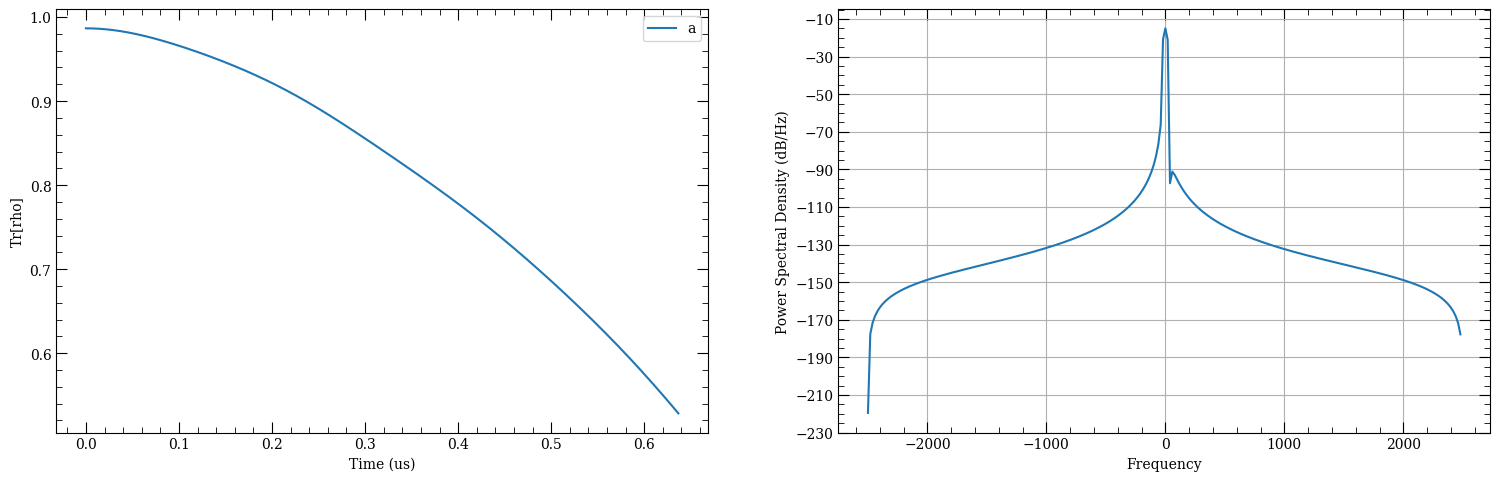

In [14]:
# print(population density on each hyperfine level)
# for i in range(0,len(t)):
#     [i]  = np.real(output.states[i].tr())
    
fig, ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 5.5)
# ax[0].plot(T*output.times*1e6, output.expect[0],label='[%] ground  F=3') 
# ax[0].plot(T*output.times*1e6, output.expect[1],label='[%] ground  F=4') 
ax[0].plot(T*output.times*1e6, output.expect[0],label='a') 
ax[0].legend()
ax[0].set_xlabel('Time (us)') 
ax[0].set_ylabel('Tr[rho]') 

# plot Fourier transform of the result
Freqs = 1/(output.times[1] - output.times[0])
FFT_meanJy = plt.psd(output.expect[0],Fs=Freqs)
plt.xlabel('Frequency')
